In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
import re
%matplotlib inline
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('data/final_df.csv')

# Feature Engineering

In [3]:
# Drop Nulls in Temperature
#df = df.dropna(subset=['weather_temperature'])

#df['stadium_wind'] = np.where((df['stadium_capacity'] > 60000) & (df['weather_wind_mph'] > 14), 1, 0)


# Drop Uneeded Rows
df = df.drop(columns=['unix', 'time', 'stadium_name','stadium_address','stadium_weather_station_code',
                      'stadium_weather_type','STATION','team_favorite_id',
                      'LATITUDE','LONGITUDE','zipcode','zipcode_away'])
 
df.drop(columns=['score_home','score_away', 'stadium_location','total'],inplace=True)
df.drop('schedule_date', axis=1,inplace=True)

# Transform Over/Under Results to Binary 0 = Under, 1 = Over
df['over_under_result'] = np.where(df['over_under_result'] == 'Over',1,0)
# Transform Stadium Surface to Binary 0 = Turf, 1 = Grass 
df['stadium_surface'] = np.where(df['stadium_surface'] == 'Grass',1,0)

# True/False to Binary 0 = False, 1 = True
df['schedule_playoff'] = list(map(int, df['schedule_playoff']))
df['stadium_neutral'] = list(map(int, df['stadium_neutral']))

# Get Dummies for Categorical Variables
df = pd.get_dummies(df, columns = ['icon'], drop_first= True)
df = pd.get_dummies(df, columns = ['summary'], drop_first= True)
#df = pd.get_dummies(df, columns = ['precipType'], drop_first= True)
df = pd.get_dummies(df, columns = ['stadium_type'], drop_first= True)
#df = pd.get_dummies(df, columns = ['stadium_name'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_home'], drop_first= True)
df = pd.get_dummies(df, columns = ['team_away'], drop_first= True)
#df = pd.get_dummies(df, columns = ['team_favorite_id'], drop_first= True)

# Transform Uint8 values to Integers
uint8_columns = list(df.select_dtypes('uint8').columns)
for colname in df.columns:
    if colname in uint8_columns:
        df[colname] = df[colname].astype(int)

df = df.dropna()

In [4]:
'team_away','team_home',

Index([], dtype='object')

# Feature Selection

In [5]:
# Split data to be used in the models
# Create matrix of features
X = df.drop('over_under_result', axis=1) # grabs everything else but 'Default'

# Create target variable
y = df['over_under_result'] # y is the column we're trying to predict

In [6]:
np.abs(df.corr()['over_under_result']).sort_values(ascending=False)

over_under_result                        1.000000
over_under_line                          0.027211
team_home_Tennessee Titans               0.026268
precipIntensity                          0.025543
windSpeed                                0.025436
                                           ...   
summary_Possible Light Rain and Humid    0.000581
team_away_New England Patriots           0.000434
stadium_type_retractable                 0.000320
summary_Heavy Snow                       0.000290
team_away_St. Louis Rams                 0.000283
Name: over_under_result, Length: 184, dtype: float64

In [7]:
corrs_dict={}
for col in X.columns:
    corr=y.corr(X[col])
    corrs_dict[corr]=col
    
sorted(corrs_dict.items(),reverse=True)

[(0.02626792349193007, 'team_home_Tennessee Titans'),
 (0.024354712902293206, 'away_SoS'),
 (0.02415829448036749, 'windBearing'),
 (0.023113033766051255, 'dist_diff'),
 (0.022529533829788985, 'home_OSRS'),
 (0.02222081648699134, 'team_home_Los Angeles Rams'),
 (0.021441202338011025, 'team_away_San Diego Chargers'),
 (0.02097769362351567, 'team_away_Indianapolis Colts'),
 (0.020972375484302037, 'away_W-L%'),
 (0.02048390534185938, 'summary_Dangerously Windy and Mostly Cloudy'),
 (0.019597493498810386, 'team_home_Denver Broncos'),
 (0.01943346889005388, 'home_MoV'),
 (0.019333203064935113, 'home_PD'),
 (0.019219367645425627, 'home_PF_per_game'),
 (0.017811704293788116, 'away_DSRS'),
 (0.01766882892533071, 'summary_Overcast'),
 (0.017489920183395465, 'elevation'),
 (0.016589932776775562, 'away_SRS'),
 (0.01629183370078582, 'team_away_Houston Oilers'),
 (0.01621484600369565, 'diff_PA_per_game'),
 (0.01603590863250397, 'team_away_Green Bay Packers'),
 (0.0154502497581088, 'icon_cloudy'),
 (

from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_(X):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif['Features'] = X.columns
    return vif
Vif = vif_(X)

Vif.sort_values('VIF',ascending=False)[:5]

# Baseline Models

### Train Test Split

In [8]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=5)

### Scale Data

In [9]:
# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X.columns)

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegressionCV

base_logreg = LogisticRegressionCV(class_weight = 'balanced')

base_logreg.fit(X_train, y_train)

base_logred_train_pred = base_logreg.predict(X_train)
base_logred_test_pred = base_logreg.predict(X_test)

base_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
base_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', base_logred_train_f1_score)
print('Test F1 score: ', base_logreg_test_f1_score)


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Train F1 score:  0.572
Test F1 score:  0.513


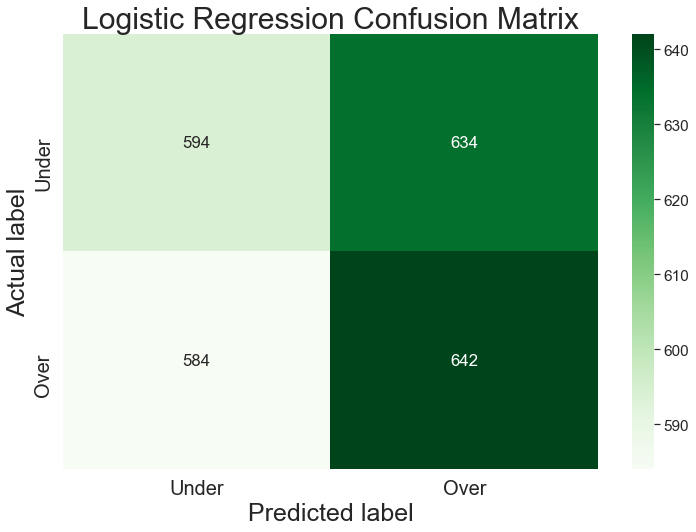

In [11]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, base_logred_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Logistic Regression Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
plt.savefig('log_confusion.png')

### Decision Tree

In [12]:
# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

dtc = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 6, min_samples_leaf = 6, min_samples_split = 6)
dtc.fit(X_train, y_train)

dtc_train_pred = dtc.predict(X_train)
dtc_test_pred = dtc.predict(X_test)

dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', dtc_f1_train)
print('Test F1 score: ', dtc_f1_test)


Train F1 score:  0.591
Test F1 score:  0.534


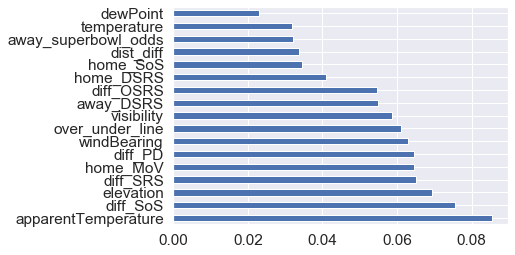

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

feat_importances = pd.Series(dtc.feature_importances_, index=X.columns)
feat_importances.nlargest(17).plot(kind='barh')
plt.show()

from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Over','Under'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

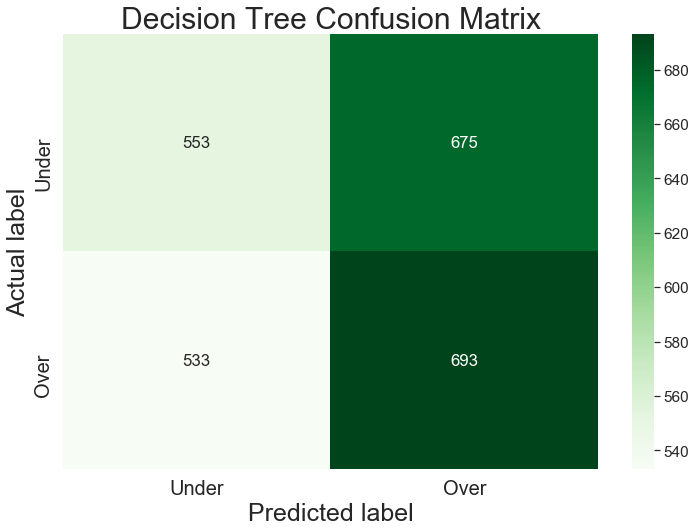

In [14]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, dtc_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Decision Tree Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', rfc_f1_train)
print('Test F1 score: ', rfc_f1_test)

Train F1 score:  0.541
Test F1 score:  0.411


Text(0.5, 44.5, 'Predicted label')

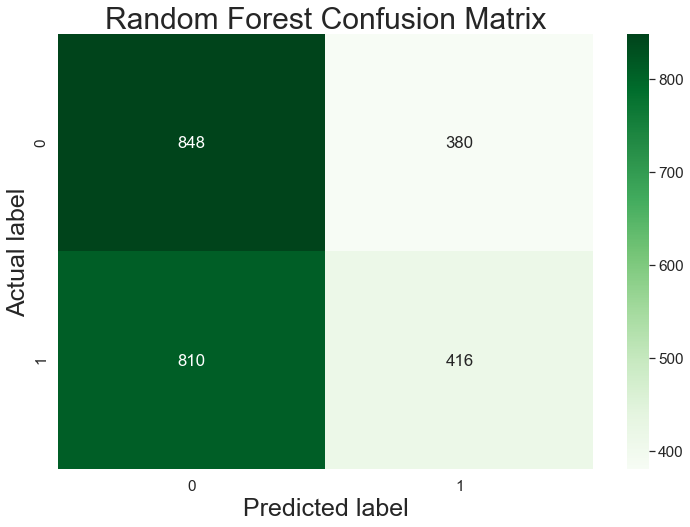

In [16]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, rfc_predicted, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Random Forest Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
#cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
#cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

### SVM Model

In [17]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)
svm_pred_train = svm.predict(X_train)

#Score
svm_f1_train = round(f1_score(y_train, svm_pred_train), 3)
svm_f1_test = round(f1_score(y_test, svm_pred), 3)

print('Train F1 score: ', svm_f1_train)
print('Test F1 score: ', svm_f1_test)

Train F1 score:  0.741
Test F1 score:  0.524


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

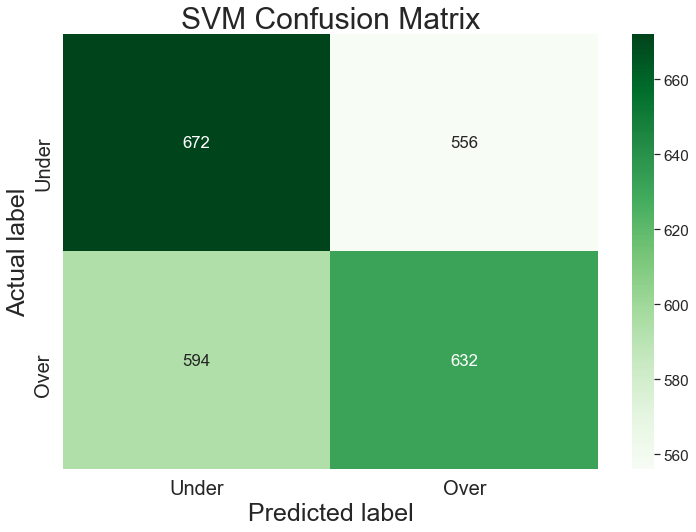

In [18]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, svm_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('SVM Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

### Final Scores 

In [19]:
print('Baseline Logistic Regression:')
print('      Train F1 score: ', base_logred_train_f1_score)
print('      Test F1 score: ', base_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Train F1 score: ', dtc_f1_train)
print('      Test F1 score: ', dtc_f1_test)
print('')
print('Random Forest:')
print('      Train F1 score: ', rfc_f1_train)
print('      Test F1 score: ', rfc_f1_test)
print('')
print('Support Vector Machine:')
print('      Train F1 score: ', svm_f1_train)
print('      Test F1 score: ', svm_f1_test)

Baseline Logistic Regression:
      Train F1 score:  0.572
      Test F1 score:  0.513

Decision Tree:
      Train F1 score:  0.591
      Test F1 score:  0.534

Random Forest:
      Train F1 score:  0.541
      Test F1 score:  0.411

Support Vector Machine:
      Train F1 score:  0.741
      Test F1 score:  0.524


# Baselines + Logistic Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
# Create recursive feature eliminator that scores features by mean squared errors
rfc_log = RFECV(estimator=LogisticRegression(),step=1, cv=5, scoring='f1', n_jobs=-1,verbose=1)

# Fit recursive feature eliminator 
rfc_log.fit(X_train, y_train)

selected_rfe = X_train.columns[rfc_log.support_]
removed_rfe = X_train.columns[~rfc_log.support_]

Fitting estimator with 183 features.
Fitting estimator with 182 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 181 features.
Fitting estimator with 180 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 179 features.
Fitting estimator with 178 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 177 features.
Fitting estimator with 176 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 175 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 174 features.
Fitting estimator with 173 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 172 features.
Fitting estimator with 171 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 170 features.
Fitting estimator with 169 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 168 features.
Fitting estimator with 167 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 166 features.
Fitting estimator with 165 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 164 features.
Fitting estimator with 163 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 162 features.
Fitting estimator with 161 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 160 features.
Fitting estimator with 159 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 158 features.
Fitting estimator with 157 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 156 features.
Fitting estimator with 155 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 154 features.
Fitting estimator with 153 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 152 features.
Fitting estimator with 151 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 150 features.
Fitting estimator with 149 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 148 features.
Fitting estimator with 147 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 146 features.
Fitting estimator with 145 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 144 features.
Fitting estimator with 143 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 142 features.
Fitting estimator with 141 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 140 features.
Fitting estimator with 139 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 138 features.
Fitting estimator with 137 features.
Fitting estimator with 136 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 135 features.
Fitting estimator with 134 features.
Fitting estimator with 133 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 132 features.
Fitting estimator with 131 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 130 features.
Fitting estimator with 129 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 128 features.
Fitting estimator with 127 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Fitting estimator with 93 features.
Fitting estimator with 92 features.


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

In [21]:
#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[selected_rfe], y,random_state=5)

In [22]:
# Scale the Data
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = X[selected_rfe].columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = X[selected_rfe].columns)

## Logistic Regression w/ RFE

In [23]:
### Logistic Regression

from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)

rfe_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
rfe_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', rfe_logred_train_f1_score)
print('Test F1 score: ', rfe_logreg_test_f1_score)


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

Train F1 score:  0.565
Test F1 score:  0.517


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

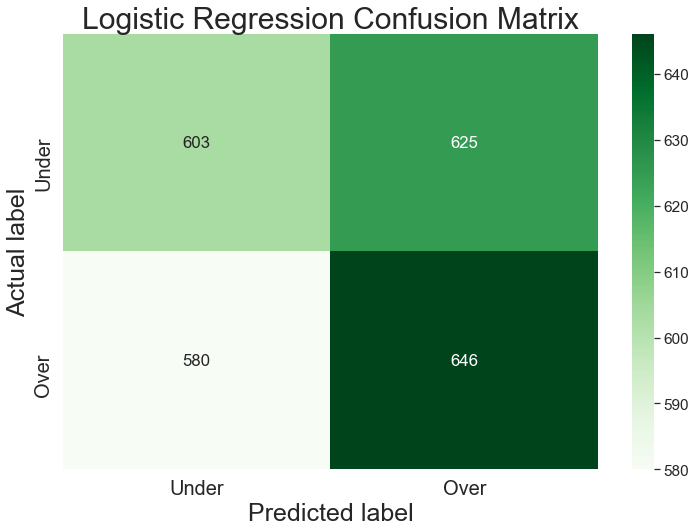

In [24]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, base_logred_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Logistic Regression Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')

## Decision Tree w/ RFE

In [25]:
### Decision Tree

# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

dtc = DecisionTreeClassifier(random_state=1, criterion = 'gini', max_depth = 6, min_samples_leaf = 6, min_samples_split = 6)
dtc.fit(X_train, y_train)

dtc_train_pred = dtc.predict(X_train)
dtc_test_pred = dtc.predict(X_test)

rfe_dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
rfe_dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', rfe_dtc_f1_train)
print('Test F1 score: ', rfe_dtc_f1_test)



Train F1 score:  0.601
Test F1 score:  0.548


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

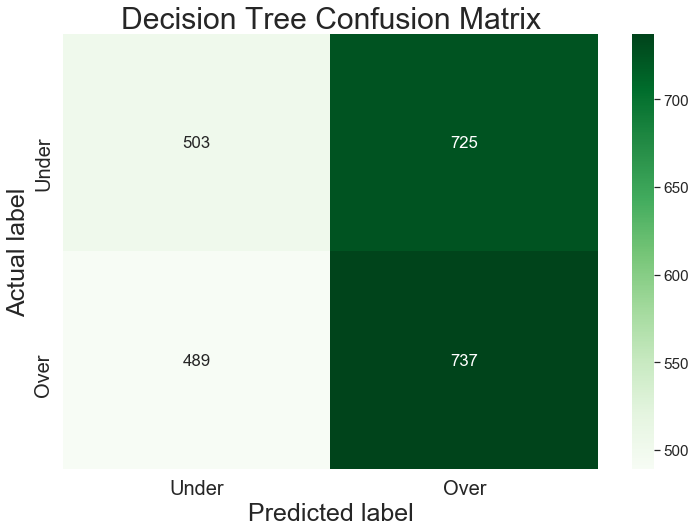

In [26]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, dtc_test_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Decision Tree Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')



## Random Forest w/ RFE

In [27]:
### Random Forest

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

rfe_rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
rfe_rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', rfe_rfc_f1_train)
print('Test F1 score: ', rfe_rfc_f1_test)

Train F1 score:  0.55
Test F1 score:  0.425


Text(0.5, 44.5, 'Predicted label')

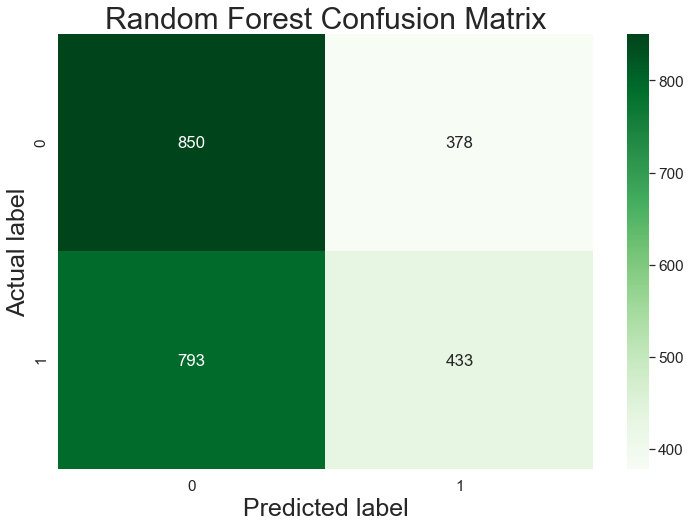

In [28]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, rfc_predicted, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('Random Forest Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
#cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
#cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')


## SVM w/ RFE

In [29]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)
svm_pred_train = svm.predict(X_train)

#Score
rfe_svm_f1_train = round(f1_score(y_train, svm_pred_train), 3)
rfe_svm_f1_test = round(f1_score(y_test, svm_pred), 3)

print('Train F1 score: ', rfe_svm_f1_train)
print('Test F1 score: ', rfe_svm_f1_test)

Train F1 score:  0.679
Test F1 score:  0.495


[Text(0, 0.5, 'Under'), Text(0, 1.5, 'Over')]

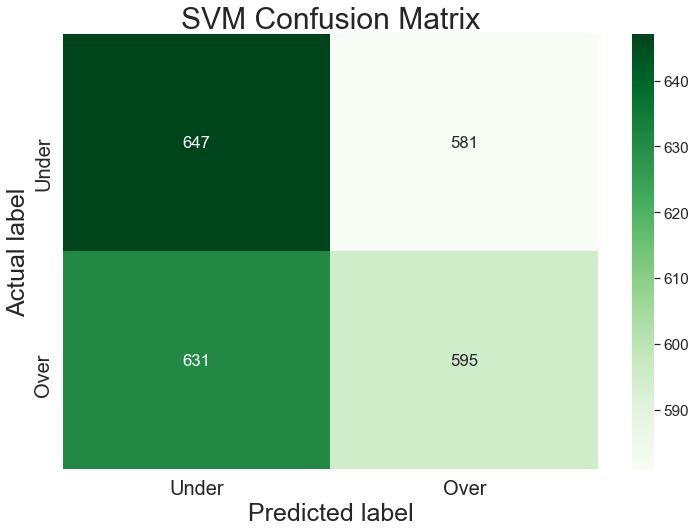

In [30]:
#Generate confusion matrix
glabels = np.unique(y_test)
gcm = confusion_matrix(y_test, svm_pred, labels=glabels) 

gcm_df = pd.DataFrame(gcm,index=glabels, columns=glabels)

#Plot
plt.figure(figsize=(12, 8))

cm = sns.set(font_scale=1.4)
cm = sns.heatmap(gcm_df,
            cmap='Greens', 
            annot=True, 
            fmt='g')

cm.set_title('SVM Confusion Matrix', fontsize = 30)
cm.set_ylabel('Actual label', fontsize = 25)
cm.set_xlabel('Predicted label', fontsize = 25)
cm.xaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)   
cm.yaxis.set_ticklabels(['Under', 'Over'], fontsize = 20)
#plt.savefig('log_confusion.png')



In [31]:
### Final Scores 

print('Baseline Logistic Regression:')
print('      Train F1 score: ', rfe_logred_train_f1_score)
print('      Test F1 score: ', rfe_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Train F1 score: ', rfe_dtc_f1_train)
print('      Test F1 score: ', rfe_dtc_f1_test)
print('')
print('Random Forest:')
print('      Train F1 score: ', rfe_rfc_f1_train)
print('      Test F1 score: ', rfe_rfc_f1_test)
print('')
print('Support Vector Machine:')
print('      Train F1 score: ', rfe_svm_f1_train)
print('      Test F1 score: ', rfe_svm_f1_test)

Baseline Logistic Regression:
      Train F1 score:  0.565
      Test F1 score:  0.517

Decision Tree:
      Train F1 score:  0.601
      Test F1 score:  0.548

Random Forest:
      Train F1 score:  0.55
      Test F1 score:  0.425

Support Vector Machine:
      Train F1 score:  0.679
      Test F1 score:  0.495


# Model Tuning w/ Polynomial Dataset

In [32]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(X[selected_rfe])
poly2_columns = poly_2.get_feature_names(X[selected_rfe].columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
print(df_poly2.shape)
df_poly2.head()

(9815, 4277)


,schedule_season,over_under_line,stadium_open,stadium_surface,dist_diff,home_W-L%,home_PD,home_MoV,home_SoS,home_SRS,home_OSRS,home_DSRS,home_PF_per_game,home_PA_per_game,away_W-L%,away_PD,away_MoV,away_SoS,away_SRS,away_OSRS,away_PF_per_game,away_PA_per_game,away_superbowl_odds,diff_W-L%,diff_PD,diff_MoV,diff_SRS,diff_OSRS,diff_PA_per_game,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,uvIndex,icon_clear-day,icon_cloudy,icon_fog,icon_partly-cloudy-day,summary_Dangerously Windy and Mostly Cloudy,summary_Dangerously Windy and Partly Cloudy,summary_Drizzle,summary_Flurries,summary_Foggy,summary_Heavy Rain and Humid,summary_Mostly Cloudy,summary_None,summary_Overcast,...,team_away_Buffalo Bills team_away_Phoenix Cardinals,team_away_Buffalo Bills team_away_Pittsburgh Steelers,team_away_Buffalo Bills team_away_St. Louis Cardinals,team_away_Buffalo Bills team_away_Tampa Bay Buccaneers,team_away_Buffalo Bills team_away_Tennessee Titans,team_away_Chicago Bears^2,team_away_Chicago Bears team_away_Green Bay Packers,team_away_Chicago Bears team_away_Indianapolis Colts,team_away_Chicago Bears team_away_Miami Dolphins,team_away_Chicago Bears team_away_Phoenix Cardinals,team_away_Chicago Bears team_away_Pittsburgh Steelers,team_away_Chicago Bears team_away_St. Louis Cardinals,team_away_Chicago Bears team_away_Tampa Bay Buccaneers,team_away_Chicago Bears team_away_Tennessee Titans,team_away_Green Bay Packers^2,team_away_Green Bay Packers team_away_Indianapolis Colts,team_away_Green Bay Packers team_away_Miami Dolphins,team_away_Green Bay Packers team_away_Phoenix Cardinals,team_away_Green Bay Packers team_away_Pittsburgh Steelers,team_away_Green Bay Packers team_away_St. Louis Cardinals,team_away_Green Bay Packers team_away_Tampa Bay Buccaneers,team_away_Green Bay Packers team_away_Tennessee Titans,team_away_Indianapolis Colts^2,team_away_Indianapolis Colts team_away_Miami Dolphins,team_away_Indianapolis Colts team_away_Phoenix Cardinals,team_away_Indianapolis Colts team_away_Pittsburgh Steelers,team_away_Indianapolis Colts team_away_St. Louis Cardinals,team_away_Indianapolis Colts team_away_Tampa Bay Buccaneers,team_away_Indianapolis Colts team_away_Tennessee Titans,team_away_Miami Dolphins^2,team_away_Miami Dolphins team_away_Phoenix Cardinals,team_away_Miami Dolphins team_away_Pittsburgh Steelers,team_away_Miami Dolphins team_away_St. Louis Cardinals,team_away_Miami Dolphins team_away_Tampa Bay Buccaneers,team_away_Miami Dolphins team_away_Tennessee Titans,team_away_Phoenix Cardinals^2,team_away_Phoenix Cardinals team_away_Pittsburgh Steelers,team_away_Phoenix Cardinals team_away_St. Louis Cardinals,team_away_Phoenix Cardinals team_away_Tampa Bay Buccaneers,team_away_Phoenix Cardinals team_away_Tennessee Titans,team_away_Pittsburgh Steelers^2,team_away_Pittsburgh Steelers team_away_St. Louis Cardinals,team_away_Pittsburgh Steelers team_away_Tampa Bay Buccaneers,team_away_Pittsburgh Steelers team_away_Tennessee Titans,team_away_St. Louis Cardinals^2,team_away_St. Louis Cardinals team_away_Tampa Bay Buccaneers,team_away_St. Louis Cardinals team_away_Tennessee Titans,team_away_Tampa Bay Buccaneers^2,team_away_Tampa Bay Buccaneers team_away_Tennessee Titans,team_away_Tennessee Titans^2
0,1979.0,30.0,1969.0,1.0,1633.703354,0.313,-18.0,-1.1,-2.2,-3.3,-4.1,0.8,15.0625,16.1875,0.438,-10.0,-0.6,-1.2,-1.8,-0.1,18.1250,18.7500,3500.0,0.125,8.0,0.5,1.5,4.0,2.5625,84.84,93.75,75.51,0.74,1012.0,13.37,91.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1979.0,36.5,1980.0,1.0,584.057748,0.750,71.0,4.4,-1.2,3.2,1.3,1.9,19.7500,15.3125,0.563,28.0,1.8,0.9,2.6,1.6,19.4375,17.6875,2000.0,0.187,43.0,2.6,0.6,0.3,2.3750,82.36,82.36,55.11,0.39,1010.5,10.52,216.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.

## Train Test Split & Scale

In [33]:
### Train Test Split

#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_poly2, y,random_state=1)

### Scale Data

# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = df_poly2.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = df_poly2.columns)

## Logistic Regression with RFE + Polynomial

In [34]:
### Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight = 'balanced')

logreg.fit(X_train, y_train)

base_logred_train_pred = logreg.predict(X_train)
base_logred_test_pred = logreg.predict(X_test)

poly_logred_train_f1_score = round(f1_score(y_train, base_logred_train_pred),3)
poly_logreg_test_f1_score = round(f1_score(y_test, base_logred_test_pred),3)

print('Train F1 score: ', poly_logred_train_f1_score)
print('Test F1 score: ', poly_logreg_test_f1_score)

Train F1 score:  0.706
Test F1 score:  0.501


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Decision Tree with RFE + Polynomial

In [35]:
### Decision Tree

# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

final_dtc = DecisionTreeClassifier(random_state=1, 
                             criterion = 'gini', 
                             max_depth = 6, 
                             min_samples_leaf = 6, 
                             min_samples_split = 6)
final_dtc.fit(X_train, y_train)

dtc_train_pred = final_dtc.predict(X_train)
dtc_test_pred = final_dtc.predict(X_test)

poly_dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
poly_dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', poly_dtc_f1_train)
print('Test F1 score: ', poly_dtc_f1_test)

Train F1 score:  0.665
Test F1 score:  0.603


## Random Forest with RFE + Polynomial

In [36]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5)
rfc.fit(X_train, y_train)
rfc_predicted = rfc.predict(X_test)
rfc_predicted_train = rfc.predict(X_train)
rfc_recall_score = metrics.recall_score(y_test, rfc_predicted)

poly_rfc_f1_train = round(f1_score(y_train, rfc_predicted_train), 3)
poly_rfc_f1_test = round(f1_score(y_test, rfc_predicted), 3)

print('Train F1 score: ', poly_rfc_f1_train)
print('Test F1 score: ', poly_rfc_f1_test)

Train F1 score:  0.645
Test F1 score:  0.467


## SVM with RFE + Polynomial

#Import svm model
from sklearn import svm

#Create a svm Classifier
svm = svm.SVC() # Linear Kernel

#Train the model using the training sets
svm.fit(X_train, y_train)

#Predict the response for test dataset
svm_pred = svm.predict(X_test)
svm_pred_train = svm.predict(X_train)

#Score
poly_svm_f1_train = round(f1_score(y_train, svm_pred_train), 3)
poly_svm_f1_test = round(f1_score(y_test, svm_pred), 3)

print('Train F1 score: ', poly_svm_f1_train)
print('Test F1 score: ', poly_svm_f1_test)

In [37]:
### Final Scores 

print('Logistic Regression:')
print('      Baseline Train F1 score: ', base_logred_train_f1_score)
print('      Baseline Test F1 score: ', base_logreg_test_f1_score)
print('      RFE Train F1 score: ', rfe_logred_train_f1_score)
print('      RFE Test F1 score: ', rfe_logreg_test_f1_score)
print('      Polynomial Train F1 score: ', poly_logred_train_f1_score)
print('      Polynomial Test F1 score: ', poly_logreg_test_f1_score)
print('')
print('Decision Tree:')
print('      Baseline Train F1 score: ', dtc_f1_train)
print('      Baselne Test F1 score: ', dtc_f1_test)
print('      RFE Train F1 score: ', rfe_dtc_f1_train)
print('      RFE Test F1 score: ', rfe_dtc_f1_test)
print('      Polynomial Train F1 score: ', poly_dtc_f1_train)
print('      Polynomial Test F1 score: ', poly_dtc_f1_test)
print('')
print('Random Forest:')
print('      Baseline Train F1 score: ', rfc_f1_train)
print('      Baseline Test F1 score: ', rfc_f1_test)
print('      RFE Train F1 score: ', rfe_rfc_f1_train)
print('      RFE Test F1 score: ', rfe_rfc_f1_test)
print('      Polynomial Train F1 score: ', poly_rfc_f1_train)
print('      Polynomial Test F1 score: ', poly_rfc_f1_test)
print('')
print('Support Vector Machine:')
print('      Baseline Train F1 score: ', svm_f1_train)
print('      Baseline Test F1 score: ', svm_f1_test)
print('      RFE Train F1 score: ', rfe_svm_f1_train)
print('      RFE Test F1 score: ', rfe_svm_f1_test)
#print('      Polynomial Train F1 score: ', poly_svm_f1_train)
#print('      Polynomial Test F1 score: ', poly_svm_f1_test)

Logistic Regression:
      Baseline Train F1 score:  0.572
      Baseline Test F1 score:  0.513
      RFE Train F1 score:  0.565
      RFE Test F1 score:  0.517
      Polynomial Train F1 score:  0.706
      Polynomial Test F1 score:  0.501

Decision Tree:
      Baseline Train F1 score:  0.591
      Baselne Test F1 score:  0.534
      RFE Train F1 score:  0.601
      RFE Test F1 score:  0.548
      Polynomial Train F1 score:  0.665
      Polynomial Test F1 score:  0.603

Random Forest:
      Baseline Train F1 score:  0.541
      Baseline Test F1 score:  0.411
      RFE Train F1 score:  0.55
      RFE Test F1 score:  0.425
      Polynomial Train F1 score:  0.645
      Polynomial Test F1 score:  0.467

Support Vector Machine:
      Baseline Train F1 score:  0.741
      Baseline Test F1 score:  0.524
      RFE Train F1 score:  0.679
      RFE Test F1 score:  0.495


# Cross Validation Scores

In [38]:
from sklearn.model_selection import cross_val_score

#### Logistic Regression

In [39]:
print(cross_val_score(base_logreg, X, y, scoring="f1", cv = 5))
mean_score = cross_val_score(base_logreg, X, y, scoring="f1", cv = 5).mean()
std_score = cross_val_score(base_logreg, X, y, scoring="f1", cv = 5).std()
print(mean_score)
print(std_score)

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

[0.49072165 0.50878073 0.50691244 0.4973822  0.46838156]


/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/alexzieky/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

0.49443571764845806
0.014579046924206867


#### Decision Tree

In [40]:
print(cross_val_score(final_dtc, df_poly2, y, scoring="f1", cv = 5))
mean_score = cross_val_score(final_dtc, df_poly2, y, scoring="f1", cv = 5).mean()
std_score = cross_val_score(final_dtc, df_poly2, y, scoring="f1", cv = 5).std()
print(mean_score)
print(std_score)

[0.47408207 0.2038835  0.51495831 0.06576402 0.08809747]
0.26935707484596727
0.19017058553211005


# Continue with Decision Tree

In [41]:
poly_3 = PolynomialFeatures(degree=3, include_bias=False)
poly3_data = poly_3.fit_transform(X[selected_rfe])
poly3_columns = poly_3.get_feature_names(X[selected_rfe].columns)
df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)
print(df_poly3.shape)
df_poly3.head()

(9815, 134043)


,schedule_season,over_under_line,stadium_open,stadium_surface,dist_diff,home_W-L%,home_PD,home_MoV,home_SoS,home_SRS,home_OSRS,home_DSRS,home_PF_per_game,home_PA_per_game,away_W-L%,away_PD,away_MoV,away_SoS,away_SRS,away_OSRS,away_PF_per_game,away_PA_per_game,away_superbowl_odds,diff_W-L%,diff_PD,diff_MoV,diff_SRS,diff_OSRS,diff_PA_per_game,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windBearing,uvIndex,icon_clear-day,icon_cloudy,icon_fog,icon_partly-cloudy-day,summary_Dangerously Windy and Mostly Cloudy,summary_Dangerously Windy and Partly Cloudy,summary_Drizzle,summary_Flurries,summary_Foggy,summary_Heavy Rain and Humid,summary_Mostly Cloudy,summary_None,summary_Overcast,...,team_away_Miami Dolphins team_away_Phoenix Cardinals^2,team_away_Miami Dolphins team_away_Phoenix Cardinals team_away_Pittsburgh Steelers,team_away_Miami Dolphins team_away_Phoenix Cardinals team_away_St. Louis Cardinals,team_away_Miami Dolphins team_away_Phoenix Cardinals team_away_Tampa Bay Buccaneers,team_away_Miami Dolphins team_away_Phoenix Cardinals team_away_Tennessee Titans,team_away_Miami Dolphins team_away_Pittsburgh Steelers^2,team_away_Miami Dolphins team_away_Pittsburgh Steelers team_away_St. Louis Cardinals,team_away_Miami Dolphins team_away_Pittsburgh Steelers team_away_Tampa Bay Buccaneers,team_away_Miami Dolphins team_away_Pittsburgh Steelers team_away_Tennessee Titans,team_away_Miami Dolphins team_away_St. Louis Cardinals^2,team_away_Miami Dolphins team_away_St. Louis Cardinals team_away_Tampa Bay Buccaneers,team_away_Miami Dolphins team_away_St. Louis Cardinals team_away_Tennessee Titans,team_away_Miami Dolphins team_away_Tampa Bay Buccaneers^2,team_away_Miami Dolphins team_away_Tampa Bay Buccaneers team_away_Tennessee Titans,team_away_Miami Dolphins team_away_Tennessee Titans^2,team_away_Phoenix Cardinals^3,team_away_Phoenix Cardinals^2 team_away_Pittsburgh Steelers,team_away_Phoenix Cardinals^2 team_away_St. Louis Cardinals,team_away_Phoenix Cardinals^2 team_away_Tampa Bay Buccaneers,team_away_Phoenix Cardinals^2 team_away_Tennessee Titans,team_away_Phoenix Cardinals team_away_Pittsburgh Steelers^2,team_away_Phoenix Cardinals team_away_Pittsburgh Steelers team_away_St. Louis Cardinals,team_away_Phoenix Cardinals team_away_Pittsburgh Steelers team_away_Tampa Bay Buccaneers,team_away_Phoenix Cardinals team_away_Pittsburgh Steelers team_away_Tennessee Titans,team_away_Phoenix Cardinals team_away_St. Louis Cardinals^2,team_away_Phoenix Cardinals team_away_St. Louis Cardinals team_away_Tampa Bay Buccaneers,team_away_Phoenix Cardinals team_away_St. Louis Cardinals team_away_Tennessee Titans,team_away_Phoenix Cardinals team_away_Tampa Bay Buccaneers^2,team_away_Phoenix Cardinals team_away_Tampa Bay Buccaneers team_away_Tennessee Titans,team_away_Phoenix Cardinals team_away_Tennessee Titans^2,team_away_Pittsburgh Steelers^3,team_away_Pittsburgh Steelers^2 team_away_St. Louis Cardinals,team_away_Pittsburgh Steelers^2 team_away_Tampa Bay Buccaneers,team_away_Pittsburgh Steelers^2 team_away_Tennessee Titans,team_away_Pittsburgh Steelers team_away_St. Louis Cardinals^2,team_away_Pittsburgh Steelers team_away_St. Louis Cardinals team_away_Tampa Bay Buccaneers,team_away_Pittsburgh Steelers team_away_St. Louis Cardinals team_away_Tennessee Titans,team_away_Pittsburgh Steelers team_away_Tampa Bay Buccaneers^2,team_away_Pittsburgh Steelers team_away_Tampa Bay Buccaneers team_away_Tennessee Titans,team_away_Pittsburgh Steelers team_away_Tennessee Titans^2,team_away_St. Louis Cardinals^3,team_away_St. Louis Cardinals^2 team_away_Tampa Bay Buccaneers,team_away_St. Louis Cardinals^2 team_away_Tennessee Titans,team_away_St. Louis Cardinals team_away_Tampa Bay Buccaneers^2,team_away_St. Louis Cardinals team_away_Tampa Bay Buccaneers team_away_Tennessee Titans,team_away_St. Louis Cardinals team_away_Tennessee Titans^2,team_away_Tampa Bay Buccaneers^3,team_away_Tampa Bay Buccaneers^2 team_away_Tennessee Titans,team_away_Tampa Bay Buc

In [42]:
### Train Test Split

#Split the Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_poly3, y,random_state=1)

### Scale Data

# Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(data = X_train, columns = df_poly3.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(data = X_test,columns = df_poly3.columns)

In [43]:
### Decision Tree

# Simple decision tree (ID3)
from sklearn.tree import DecisionTreeClassifier 

final_dtc = DecisionTreeClassifier(random_state=1, 
                             criterion = 'entropy', 
                             max_depth = 6, 
                             min_samples_leaf = 6, 
                             min_samples_split = 6)
final_dtc.fit(X_train, y_train)

dtc_train_pred = final_dtc.predict(X_train)
dtc_test_pred = final_dtc.predict(X_test)

poly3_dtc_f1_train = round(f1_score(y_train, dtc_train_pred),3)
poly3_dtc_f1_test = round(f1_score(y_test, dtc_test_pred), 3)

print('Train F1 score: ', poly3_dtc_f1_train)
print('Test F1 score: ', poly3_dtc_f1_test)

Train F1 score:  0.653
Test F1 score:  0.621


scores = cross_val_score(final_dtc, df_poly3, y, scoring="f1", cv = 5)
mean_score = scores.mean()
std_score = scores.std()
print(scores)
print(mean_score)
print(std_score)

In [48]:
from sklearn.model_selection import GridSearchCV
# find the best hyperparameters for simple decision tree
parameters={'max_depth': range(3,10,1),  
            'min_samples_split':range(1,50,5),
            'min_samples_leaf':range(1,50,5),
            'criterion': ['gini', 'entropy'] 
           }

dtc = DecisionTreeClassifier(random_state=1)

tree_g = GridSearchCV(dtc, parameters, cv=5, scoring='f1', verbose = 1,  n_jobs = -1)
tree_g.fit(X_train,y_train)

print(tree_g.best_params_, ': ', tree_g.best_score_)

y_pred = tree_g.best_estimator_.predict(X_test)    
y_pred_train = tree_g.best_estimator_.predict(X_train)    

f1_train = round(f1_score(y_train, y_pred_train), 3)
f1_test = round(f1_score(y_test, y_pred), 3)

print('Train F1 score: ', f1_train)
print('Test F1 score: ', f1_test)

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 